<a href="https://colab.research.google.com/github/zerokinetic/preventing-brigading-in-reddit/blob/main/notebooks/detection_framework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/sna/Preventing-Brigading-in-Reddit/dataset/1month.csv")

# PART 1: TEMPORAL PATTERN ANALYSIS

In [3]:
df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'])

# 1. Burst detection in cross-posting activity

In [4]:
# Group by target subreddit and resample to detect spikes in activity
cross_post_activity = df.groupby('TARGET_SUBREDDIT').resample('H', on='TIMESTAMP').size().unstack(fill_value=0)

# Calculate moving average and standard deviation to identify bursts
window_size = 24
moving_avg = cross_post_activity.rolling(window=window_size).mean()
moving_std = cross_post_activity.rolling(window=window_size).std()

# Identify bursts where activity is significantly higher than average (e.g., > 3 std deviations)
bursts = cross_post_activity[(cross_post_activity > moving_avg + 3 * moving_std) & (moving_std > 0)]

print("Burst detection in cross-posting activity (hourly bursts identified by target subreddit and timestamp):")
print(bursts.stack().reset_index(name='burst_count'))
print("-" * 50)

<ipython-input-4-4059895095>:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  cross_post_activity = df.groupby('TARGET_SUBREDDIT').resample('H', on='TIMESTAMP').size().unstack(fill_value=0)


Burst detection in cross-posting activity (hourly bursts identified by target subreddit and timestamp):
         TARGET_SUBREDDIT           TIMESTAMP  burst_count
0                abcdesis 2014-01-07 01:00:00          1.0
1                abcdesis 2014-01-14 23:00:00          1.0
2                 ableton 2014-01-03 01:00:00          1.0
3      abstergoindustries 2014-01-01 11:00:00          1.0
4        abuseinterrupted 2014-01-20 17:00:00          1.0
...                   ...                 ...          ...
12111           zenhabits 2014-01-19 19:00:00          1.0
12112                zeos 2014-01-13 05:00:00          1.0
12113             zidisha 2014-01-04 18:00:00          1.0
12114               zizek 2014-01-15 16:00:00          1.0
12115             zoology 2014-01-14 10:00:00          1.0

[12116 rows x 3 columns]
--------------------------------------------------


# 2. Synchronous posting patterns across multiple subreddits

In [5]:
# Identify timestamps with high cross-posting activity across multiple targets
synchronous_activity = cross_post_activity[(cross_post_activity > 0).sum(axis=1) > 1] # Timestamps with activity in more than 1 subreddit

print("Synchronous posting patterns across multiple subreddits (hourly activity in more than one target subreddit):")
print(synchronous_activity)
print("-" * 50)

Synchronous posting patterns across multiple subreddits (hourly activity in more than one target subreddit):
TIMESTAMP         2013-12-31 16:00:00  2013-12-31 17:00:00  \
TARGET_SUBREDDIT                                             
3amjokes                            0                    0   
3d6                                 0                    0   
3dprinting                          0                    0   
3ds                                 0                    0   
3dsgamenight                        0                    0   
...                               ...                  ...   
youtube                             0                    0   
youtubescience                      0                    0   
yugioh                              0                    0   
zen                                 0                    0   
zenhabits                           0                    0   

TIMESTAMP         2013-12-31 18:00:00  2013-12-31 19:00:00  \
TARGET_SUBREDDIT      

# 3. Abnormal activity spikes in specific time window

In [6]:
# This is similar to burst detection but can be applied to the overall activity or specific source/target pairs.
# Let's look at overall posting activity
overall_activity = df.resample('H', on='TIMESTAMP').size()

overall_moving_avg = overall_activity.rolling(window=window_size).mean()
overall_moving_std = overall_activity.rolling(window=window_size).std()

overall_spikes = overall_activity[(overall_activity > overall_moving_avg + 3 * overall_moving_std) & (overall_moving_std > 0)]

print("Abnormal activity spikes in specific time window (overall hourly activity spikes):")
print(overall_spikes)
print("-" * 50)

Abnormal activity spikes in specific time window (overall hourly activity spikes):
TIMESTAMP
2014-01-13 12:00:00     50
2014-01-17 14:00:00    144
2014-01-22 15:00:00     55
dtype: int64
--------------------------------------------------


<ipython-input-6-3894650169>:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  overall_activity = df.resample('H', on='TIMESTAMP').size()


# PART 2: SENTIMENT COORDINATION DETECTION

# 1. Analyze sentiment distribution patterns

In [7]:
# Sentiment label is in the 'LINK_SENTIMENT' column
sentiment_distribution = df['LINK_SENTIMENT'].value_counts(normalize=True)
print("Sentiment distribution patterns:")
print(sentiment_distribution)
print("-" * 50)

Sentiment distribution patterns:
LINK_SENTIMENT
 1    0.90609
-1    0.09391
Name: proportion, dtype: float64
--------------------------------------------------


In [8]:
# Analyze sentiment distribution by target subreddit
sentiment_by_target = df.groupby('TARGET_SUBREDDIT')['LINK_SENTIMENT'].value_counts(normalize=True).unstack(fill_value=0)
print("Sentiment distribution by target subreddit:")
print(sentiment_by_target)
print("-" * 50)

Sentiment distribution by target subreddit:
LINK_SENTIMENT     -1    1
TARGET_SUBREDDIT          
195               0.0  1.0
2007scape         0.0  1.0
24hoursupport     0.0  1.0
3amjokes          0.0  1.0
3d6               0.0  1.0
...               ...  ...
zenhabits         0.5  0.5
zeos              0.0  1.0
zidisha           0.0  1.0
zizek             0.0  1.0
zoology           0.0  1.0

[2714 rows x 2 columns]
--------------------------------------------------


# 2. Detect unusual sentiment unanimity

In [9]:
# Look for target subreddits where one sentiment dominates heavily
sentiment_unanimity_threshold = 0.95 # e.g., more than 95% of posts have the same sentiment
unanimous_sentiment = sentiment_by_target[(sentiment_by_target > sentiment_unanimity_threshold).any(axis=1)]
print(f"Target subreddits with unusual sentiment unanimity (> {sentiment_unanimity_threshold*100}%):")
print(unanimous_sentiment)
print("-" * 50)

Target subreddits with unusual sentiment unanimity (> 95.0%):
LINK_SENTIMENT     -1    1
TARGET_SUBREDDIT          
195               0.0  1.0
2007scape         0.0  1.0
24hoursupport     0.0  1.0
3amjokes          0.0  1.0
3d6               0.0  1.0
...               ...  ...
zen               0.0  1.0
zeos              0.0  1.0
zidisha           0.0  1.0
zizek             0.0  1.0
zoology           0.0  1.0

[2319 rows x 2 columns]
--------------------------------------------------


# 3. Identify rapid sentiment shifts

In [10]:
# Analyze sentiment changes over time for specific target subreddits
# Resample sentiment by hour and calculate the dominant sentiment or mean sentiment
sentiment_over_time = df.groupby('TARGET_SUBREDDIT').resample('H', on='TIMESTAMP')['LINK_SENTIMENT'].mean().unstack()

<ipython-input-10-3386776654>:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  sentiment_over_time = df.groupby('TARGET_SUBREDDIT').resample('H', on='TIMESTAMP')['LINK_SENTIMENT'].mean().unstack()


In [11]:
# Calculate the difference in mean sentiment between consecutive hours
sentiment_shifts = sentiment_over_time.diff()

In [12]:
# Identify shifts larger than a certain threshold
shift_threshold = 0.5 # e.g., mean sentiment changes by more than 0.5 in an hour
rapid_sentiment_shifts = sentiment_shifts[abs(sentiment_shifts) > shift_threshold].stack().reset_index(name='sentiment_shift')

In [13]:
print(f"Rapid sentiment shifts (mean sentiment change > {shift_threshold} in an hour):")
print(rapid_sentiment_shifts)
print("-" * 50)

Rapid sentiment shifts (mean sentiment change > 0.5 in an hour):
     TARGET_SUBREDDIT           TIMESTAMP  sentiment_shift
0               4chan 2014-01-05 17:00:00         2.000000
1           askreddit 2014-01-02 18:00:00        -1.000000
2          askscience 2014-01-07 08:00:00        -2.000000
3          askscience 2014-01-16 11:00:00        -2.000000
4          askscience 2014-01-25 13:00:00         1.000000
5          askscience 2014-01-27 12:00:00         0.666667
6        circlebroke2 2014-01-11 01:00:00        -2.000000
7         environment 2014-01-02 09:00:00         2.000000
8           excelporn 2014-01-22 18:00:00        -2.000000
9            facepalm 2014-01-12 07:00:00        -1.000000
10        fantheories 2014-01-28 19:00:00        -2.000000
11  fitnesscirclejerk 2014-01-09 10:00:00        -2.000000
12     litecoinmining 2014-01-24 07:00:00        -2.000000
13       philadelphia 2014-01-05 15:00:00        -2.000000
14               pics 2014-01-21 17:00:00         

# Community Detection for Coordinated Groups

In [14]:
!pip install networkx community leidenalg

import networkx as nx
import community as community_louvain # Using the python-louvain library
import matplotlib.pyplot as plt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 100.4 MB/s eta 0:00:00


In [15]:
# Build a graph representing interactions between subreddits
# We can represent edges based on cross-posting activity between SOURCE_SUBREDDIT and TARGET_SUBREDDIT

# Create a directed graph
G = nx.DiGraph()

# Add nodes for all unique subreddits involved in cross-posting
all_subreddits = pd.concat([df['SOURCE_SUBREDDIT'], df['TARGET_SUBREDDIT']]).unique()
G.add_nodes_from(all_subreddits)

# Add edges based on cross-posting frequency
# Count the frequency of each source-target pair
edge_weights = df.groupby(['SOURCE_SUBREDDIT', 'TARGET_SUBREDDIT']).size().reset_index(name='weight')

# Add edges to the graph with weights
for index, row in edge_weights.iterrows():
  G.add_edge(row['SOURCE_SUBREDDIT'], row['TARGET_SUBREDDIT'], weight=row['weight'])

In [16]:
# Convert the directed graph to an undirected graph for community detection
# Louvain algorithm is typically applied to undirected graphs.
# We can sum the weights of reciprocal edges if they exist.
G_undirected = G.to_undirected()
# Handle potential multiple edges between the same nodes after conversion
G_undirected = nx.Graph(G_undirected) # This should merge edges if they exist

# Remove self-loops if any were created
G_undirected.remove_edges_from(nx.selfloop_edges(G_undirected))

# Apply the Louvain algorithm to find communities
# The partition is a dictionary where keys are nodes and values are community ids.
partition = community_louvain.best_partition(G_undirected)

# Print the communities found
print("Communities found using Louvain Algorithm:")
community_dict = {}
for node, community_id in partition.items():
  if community_id not in community_dict:
    community_dict[community_id] = []
  community_dict[community_id].append(node)

for community_id, nodes in community_dict.items():
  print(f"Community {community_id}: {nodes}")

print("-" * 50)

Communities found using Louvain Algorithm:
Community 0: ['rddtgaming', 'rddtrust', 'garrysmod']
Community 1: ['xboxone', 'ps4', 'allthingsterran', 'allthingszerg', 'battlefield_4', 'gaming', 'drugmemes', 'truestl', 'metalgear', 'trailerparkboys', 'homestuck', 'psminecraft', 'turbografx', 'dota2', 'pcmasterrace', 'starcraftcirclejerk', 'shittydarksouls', 'gaben', 'gamingcirclejerk', 'singlechampchallenge', 'pcgaming', 'skyrimmods', 'elderscrollsonline', 'test', 'esports', 'steam', 'leagueoflegends', 'shittyteslore', 'destiny', 'wassup', 'yogscast', 'bf4server', 'summoners', 'fweddit', 'ssbpm', 'mwo', 'darksouls', 'nyxnyxnyx', 'skyrim', 'reddit_refugees', 'smashbros', 'eq2', 'howtocomputer', 'everquest', 'eqnext', 'fallout', 'edc', 'yms', 'giveaway', 'toasterrights', 'halflife', 'starcraft', 'globaloffensive', 'bfvoip', 'quakelive', 'dartlang', 'vodsbeta', 'vodsprivate', 'loleventvods', 'psbf', 'ashens', 'futile', 'indiegaming', 'woodmanps2', 'crappydesign', 'planetside', 'letsjerk', 'de

<ipython-input-17-3348653855>:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis', max(partition.values()) + 1)


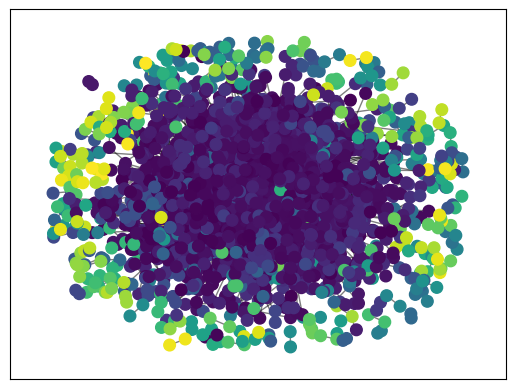

In [17]:
try:
    pos = nx.spring_layout(G_undirected) # Positions for all nodes
    cmap = plt.cm.get_cmap('viridis', max(partition.values()) + 1)
    nx.draw_networkx_nodes(G_undirected, pos, node_size=70, cmap=cmap, node_color=list(partition.values()))
    nx.draw_networkx_edges(G_undirected, pos, alpha=0.5)
    plt.show()
except Exception as e:
    print(f"Could not visualize graph due to error: {e}")
    print("Graph visualization might be slow or fail for large graphs.")
    print("Consider using tools like Gephi for visualization of large graphs.")

In [18]:
def girvan_newman(graph, levels=float('inf')):
  """
    Applies the Girvan-Newman community detection algorithm.

    Args:
      graph: A networkx graph.
      levels: The maximum number of community splits to perform.

    Returns:
      A list of community sets at each level of the algorithm.
  """
  communities = [set(graph.nodes())]
  graph_copy = graph.copy()
  level = 0

  while graph_copy.number_of_edges() > 0 and level < levels:
    # Calculate edge betweenness centrality
    ebc = nx.edge_betweenness_centrality(graph_copy)
    # Find edge(s) with the highest betweenness centrality
    max_ebc = max(ebc.values())
    edges_to_remove = [edge for edge, betweenness in ebc.items() if betweenness == max_ebc]

    # Remove the edge(s) with the highest betweenness centrality
    graph_copy.remove_edges_from(edges_to_remove)

    # Find the connected components (which are the communities)
    current_communities = list(nx.connected_components(graph_copy))
    communities.append(set().union(*current_communities)) # Store the union of communities for visualization if needed
    level += 1

    # Check if removing the edge(s) split the graph into more than one component
    if len(current_communities) > len(communities[-2]):
        communities[-1] = current_communities # Store the actual community sets if a split occurred

  return communities[2:] # Return communities starting from the first split


In [19]:
# Implement Girvan-Newman on the undirected graph
# Let's limit the levels to prevent excessively long runtimes for large graphs
gn_communities = girvan_newman(G_undirected, levels=2) # Adjust levels as needed

print("Communities found using Girvan-Newman Algorithm (hierarchical):")
for level, community_set in enumerate(gn_communities):
    print(f"Level {level + 1} communities:")
    for i, comm in enumerate(community_set):
        print(f"  Community {i + 1}: {comm}")
    print("-" * 20)

Communities found using Girvan-Newman Algorithm (hierarchical):
Level 1 communities:
  Community 1: shittydayzsuggestions
  Community 2: yvonnestrahovski
  Community 3: askreddit
  Community 4: reunionisland
  Community 5: swiftmangacomics
  Community 6: moderationtheory
  Community 7: bitcoinseattle
  Community 8: christianity
  Community 9: funnysigns
  Community 10: modernculture
  Community 11: cubeproject
  Community 12: rockets
  Community 13: mcvenom
  Community 14: mma
  Community 15: shitstatistssay
  Community 16: icefishing
  Community 17: jailbreak
  Community 18: mlpccg
  Community 19: nononono
  Community 20: nofapchristians
  Community 21: spacedandy
  Community 22: stims
  Community 23: academicphilosophy
  Community 24: windowsphone
  Community 25: srsmeta
  Community 26: randomactsofcards
  Community 27: vertcoin
  Community 28: makeupaddiction
  Community 29: masudaexchange
  Community 30: vietnam
  Community 31: music
  Community 32: sanjosesharks
  Community 33: un

<ipython-input-20-3573985534>:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis', len(viz_communities))


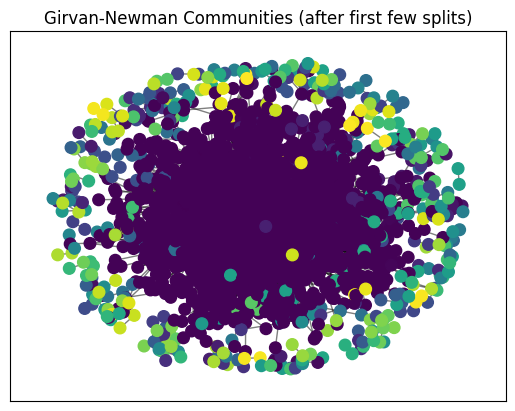

In [20]:
# We will visualize the graph after removing edges from the first few steps of Girvan-Newman

try:
    # Visualize the graph after the first few splits
    graph_for_viz = G_undirected.copy()
    if len(gn_communities) > 0:
      # Get the edges that were removed in the first few steps
      removed_edges_viz = []
      temp_graph = G_undirected.copy()
      for level in range(min(3, len(gn_communities))): # Visualize after first 3 splits
        ebc_temp = nx.edge_betweenness_centrality(temp_graph)
        max_ebc_temp = max(ebc_temp.values())
        edges_to_remove_temp = [edge for edge, betweenness in ebc_temp.items() if betweenness == max_ebc_temp]
        removed_edges_viz.extend(edges_to_remove_temp)
        temp_graph.remove_edges_from(edges_to_remove_temp)

      graph_for_viz.remove_edges_from(removed_edges_viz)
      viz_communities = list(nx.connected_components(graph_for_viz))
      node_colors = {}
      for i, comm in enumerate(viz_communities):
          for node in comm:
              node_colors[node] = i

      if node_colors:
          pos = nx.spring_layout(G_undirected) # Use layout based on original graph for consistency
          cmap = plt.cm.get_cmap('viridis', len(viz_communities))
          colors = [node_colors.get(node, -1) for node in G_undirected.nodes()] # -1 for nodes not in visualized communities
          nx.draw_networkx_nodes(G_undirected, pos, node_size=70, cmap=cmap, node_color=colors)
          nx.draw_networkx_edges(graph_for_viz, pos, alpha=0.5) # Draw edges of the graph after removal
          plt.title("Girvan-Newman Communities (after first few splits)")
          plt.show()
      else:
          print("Could not generate node colors for visualization.")
    else:
      print("No communities found at initial levels for visualization.")

except Exception as e:
    print(f"Could not visualize Girvan-Newman communities due to error: {e}")
    print("Graph visualization might be slow or fail for large graphs.")
    print("Consider using tools like Gephi for visualization of large graphs.")

In [32]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [33]:
bursts_data = bursts.stack().reset_index(name='burst_count')
bursts_data['TIMESTAMP_NUM'] = bursts_data['TIMESTAMP'].astype(np.int64) // 10**9 # Convert to Unix timestamp

# Select features for clustering: Timestamp and burst count
# We might also consider one-hot encoding the target subreddit if we want
# to cluster based on subreddit and temporal patterns simultaneously.
# For a simple DBSCAN focusing on dense temporal/activity regions, we'll use timestamp and count.
X = bursts_data[['TIMESTAMP_NUM', 'burst_count']].values

# Scale the features. DBSCAN is sensitive to scale.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [34]:
dbscan = DBSCAN(eps=0.5, min_samples=5) # Example values, tune as needed
clusters = dbscan.fit_predict(X_scaled)

# Add the cluster labels back to the original bursts_data DataFrame
bursts_data['cluster'] = clusters

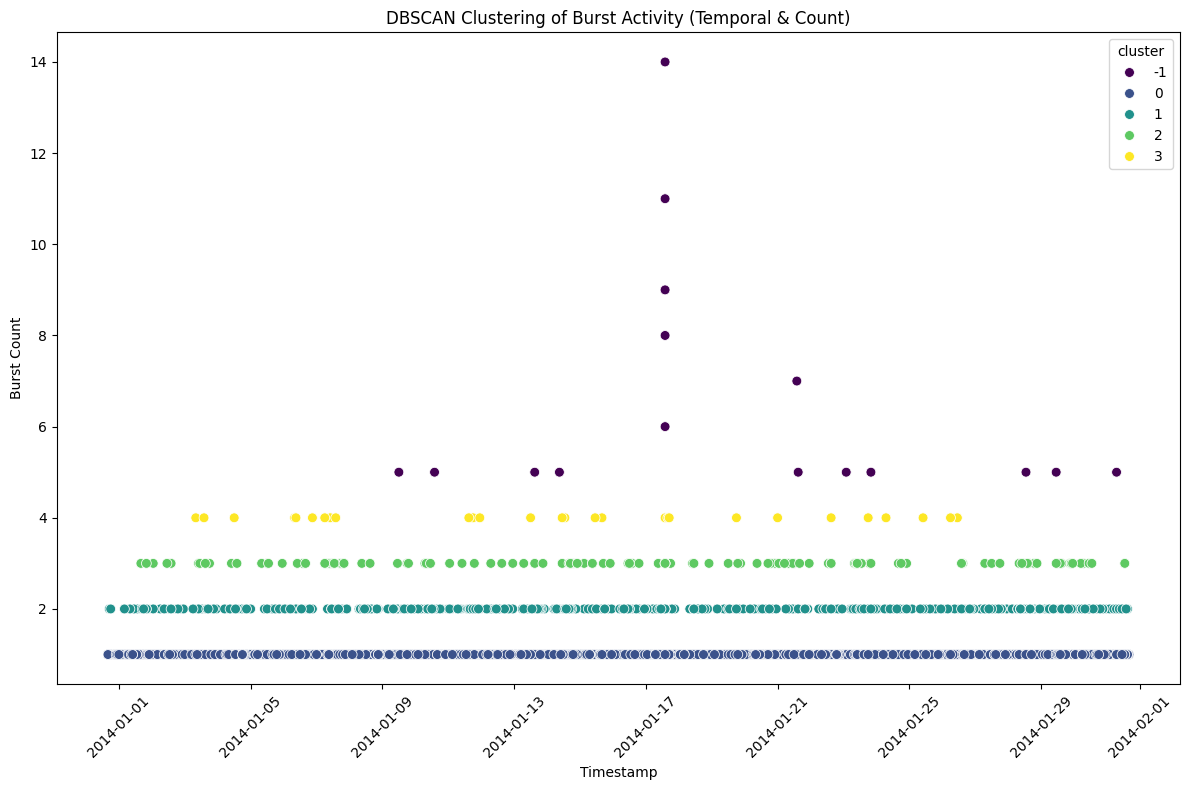

DBSCAN Clustering Results:
cluster
0    [abcdesis, abcdesis, ableton, abstergoindustri...
1    [adventuretime, adviceanimals, adviceanimals, ...
2    [adviceanimals, adviceanimals, adviceanimals, ...
3    [adviceanimals, ask_politics, askreddit, askre...
Name: TARGET_SUBREDDIT, dtype: object
17 noise points identified.
--------------------------------------------------


In [35]:
# Visualize the results
# Plot the original burst points, colored by their cluster label.
# Noise points are labeled as -1.
plt.figure(figsize=(12, 8))
sns.scatterplot(data=bursts_data, x='TIMESTAMP', y='burst_count', hue='cluster', palette='viridis', legend='full', s=50)
plt.title('DBSCAN Clustering of Burst Activity (Temporal & Count)')
plt.xlabel('Timestamp')
plt.ylabel('Burst Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("DBSCAN Clustering Results:")
print(bursts_data[bursts_data['cluster'] != -1].groupby('cluster')['TARGET_SUBREDDIT'].apply(list))
print(bursts_data[bursts_data['cluster'] == -1].shape[0], "noise points identified.")
print("-" * 50)